In [1]:
# Load dependencies 
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from collections import defaultdict

# Year of intersection uncertainty
To evaluate the uncertainty in the year anthropogenic mass is expected to surpass biomass we conduct a Monte Carlo error estimation.
The following function is used throughout the code to find the exact time of intersection between anthropogenic mass and biomass in a known range. 

In [2]:
def line_intersection(line1, line2):
    """
    finds the intersection point of two straight lines
    from: https://stackoverflow.com/questions/20677795/how-do-i-compute-the-intersection-point-of-two-lines-in-python
    by: @paul-draper
    :param line1: 2 point defining a line
    :type line1: tuple
    :param line2: 2 point defining a line
    :type line2: tuple
    :return: x & y coordinates of the intersection point of the two given lines
    :rtype: tuple
    """
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
        raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [3]:
# Load tabular data
file_path = os.path.abspath('')

bm_est = pd.read_excel(file_path + "/../biomass_calculation/bm_est.xlsx", index_col ="data source")
dgvm = pd.read_excel(file_path + "/../biomass_calculation/DGVM_mean.xlsx")
anth_dry_2015 = (pd.read_excel(file_path + "/../data/anthropogenic_mass_2015.xlsx", index_col='Year')).iloc[:,:7]

## Simulation core machinery
 
The following functions are the heart of the simulation.
The function get_BM() follows "biomass_calculation.ipynb", with the sole difference of randomly drawing the parameters, instead of using constant values.

## Run simulation

The simulation runs *num_of_iterations* times.
The simulation extrapolates the anthropogenic mass and biomass until the year 2080. This is done in order to sample the intersection year distribution in an unbiased manner (insufficient extrapolation will result in a left skewed distribution).

In [4]:
def get_BM():
    bm_tot= defaultdict(list)
    approach1= defaultdict(list)
    approach2 = defaultdict(list) 
    PLANTS_BM = np.random.normal(450, 45)
    NON_PLANT_BM = np.random.lognormal(np.log(48.2), np.log(1.9)/1.96)
    FOREST_FRAC = np.random.normal(0.75,0.03)
    CFACTOR = np.random.normal(2.25,0.13)
    z = np.random.normal(0,1)
    d = []
    for i in xrange(len(dgvm)):
        d.append((z*dgvm.iloc[i,2]) + dgvm.iloc[i,1])
    dgvm1 = pd.DataFrame({'year': dgvm.iloc[:,0], 'dmean': d}, columns=['year', 'dmean'])
    # Plants biomass 1990-2017
    for source in set(bm_est.index):
        est_dic = dict(zip(np.array(bm_est.loc[source]['year']), np.array(bm_est.loc[source]['biomass [GtC]'])))
        for year in est_dic.keys():
            if year != 2010:
                if (source == 'Liu et al.'):
                    approach1[year].append(est_dic[year]/est_dic[2010] * PLANTS_BM)
                if (source == 'DGVM'):
                    approach2[year].append(dgvm1.iloc[year-1900,1]/est_dic[2010] * PLANTS_BM)
                if (source == 'FRA2010') or (source == 'Pan et al.') or (source == 'FAOstat'):
                    approach1[year].append(((est_dic[year]*(1/FOREST_FRAC))/(est_dic[2010]*(1/FOREST_FRAC))) * PLANTS_BM )
    bm_plants = {2010: PLANTS_BM}
    for year in ([1990,2000,2012,2017]):
        bm_plants[year] = (np.mean(np.array([np.random.normal(np.mean(approach1[year]),np.std(approach1[year])) ,approach2[year][0]])))
    # Plants biomass 1900-1990
    for i in xrange(90):
        bm_plants[1900+i]= (dgvm1.iloc[i,1]/dgvm1.iloc[90,1]* bm_plants[1990])          

    # Overall biomass 
    for y in bm_plants.keys():
        bm_tot[y].append((bm_plants[y]+ NON_PLANT_BM)* CFACTOR)
    bm = np.empty(0)
    years = np.array(sorted(bm_tot.keys()))
    for y in sorted(years):
        bm = np.append(bm,bm_tot[y])

    # Calculate rate of change 2010-2017 
    trend = np.polyfit(years[-3:],bm[-3:],1)[0]

    # Apply the rate to future years 
    years_ext = np.linspace(2018,2080,63)
    for i in xrange(len(years_ext)):
        bm = np.append(bm,bm[-1]+trend)

    years = np.concatenate([years,years_ext])

    bm_f = np.empty(0)
    for i in xrange (len(bm)-1):
        bm_f = np.append(bm_f,np.linspace(bm[i],bm[i+1],int(years[i+1]-years[i]+1))[:-1])  
    bm_f = np.append(bm_f, bm[-1])
    return bm_f

def get_AM_by_factor():
    """
    Multiplies the deterministic anthropogenic mass timeline by a random factor, corresponding to the error
    distribution of the anthropogenic mass and waste cumulative mass
    :return: timeline anthropogenic mass and waste fractions
    :rtype: pd.DataFrame
    """
    in_use_factor = np.random.normal(1, 0.05/3, 1) 
    waste_factor = np.random.normal(1, 0.15/3, 1)
    out_df = pd.concat([ANTHROPO_IN_USE * in_use_factor, anth_dry_raw['waste'] * waste_factor],
                       axis=1,
                       keys=['in-use', 'waste'])
    return out_df


def intersection_time(bm, am):
    """
    Gets two timelines and finds time of intersection
    :param bm: biomass timeline
    :type: np.array or pd.Series
    :param am: anthropogenic mass timeline
    :type: np.array or pd.Series
    :return: time of intersection between the two timelines
    :rtype: tuple
    """
    mass_dif = bm - am
    try:
        # Find where the difference between biomass and anthropogenic mass exceeds zero (i.e. there is more anthropogenic mass)
        year = mass_dif.gt(0).idxmin()
    except ValueError:
        print('No max')
        return
    # Use the year found above to define straight lines - one for the biomass and one for the anthropogenic mass 
    bm_a, bm_b = (year - 1, bm[year - 1]), (year, bm[year])
    am_a, am_b = (year - 1, am[year - 1]), (year, am[year])
    # Call helper function to find the exact time the lines intersect
    return line_intersection((bm_a, bm_b), (am_a, am_b))[0]


def get_year_uncertainty(bm, num):
    """
    Finds distribution of years of intersection between biomass and anthropogenic mass by Monte Carlo simulation
    :param bm: multiple biomass timelines
    :type: pd.DataFrame
    :param num: the number of iterations the simulation should make
    :type: int
    :return: anthropogenic mass timlines of in-use, waste and total fractions, years of intersection
    between anthropogenic mass and biomass as predicted by the simulation
    :rtype: pd.Series, pd.Series, pd.Series, np.array, np.array
    """
    am_in_use = pd.DataFrame()
    am_waste = pd.DataFrame()
    am_total = pd.DataFrame()
    y_in_use = np.empty(0)
    y_total = np.empty(0)
    for j in xrange(num):
        tmp = get_AM_by_factor()
        am_in_use[j] = tmp['in-use']
        am_waste[j] = tmp['waste']
        am_total[j] = tmp['in-use'] + tmp['waste']
        bm_rand = bm.iloc[j, :]
        # For each random couple of timelines - of Biomass and Anthropogenic mass - find the time of intersection and append to array 
        y_in_use = np.append(y_in_use, intersection_time(bm_rand, am_in_use[j]))
        y_total = np.append(y_total, intersection_time(bm_rand, am_total[j]))
    return am_in_use, am_waste, am_total, y_in_use, y_total

In [5]:
num_of_iterations = 10000
BM_dry_MC = pd.DataFrame([get_BM() / 1000 for _ in range(num_of_iterations)], 
                         columns=np.linspace(1900, 2080, 181, dtype=np.int))

BM_wet_MC = BM_dry_MC.apply(lambda row: row * np.random.normal(2.0, 0.3), axis=1)

factors = (anth_dry_2015.iloc[-5:, :] / anth_dry_2015.shift(1).iloc[-5:, :]).mean()
anth_dry_2080 = pd.DataFrame([anth_dry_2015.iloc[-1, :] * (factors ** i) for i in range(66)], index=range(2015, 2081))
anth_dry_raw = pd.concat([anth_dry_2015, anth_dry_2080.iloc[1:, :]])

# Initializing with 1900 values 
anth1900 = [0.002258563,0.016639681,0.011143095, 0 ,0.000838412,0.004274367, 0]
anth_dry_raw = anth_dry_raw.shift(periods=1)
anth_dry_raw.iloc[0,:] = anth1900

ANTHROPO_IN_USE = anth_dry_raw.iloc[:, :-1].sum(axis=1)

anth_in_use_dry, anth_waste_dry, anth_total_dry, year_in_use_dry, year_total_dry = get_year_uncertainty(BM_dry_MC, num_of_iterations)

## Results

### anthropogenic mass vs. dry biomass

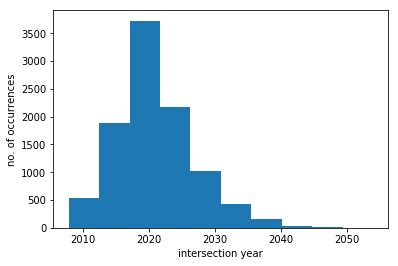

Year of anthropogenic mass intersection with dry biomass: mean = 2020 std = 6


In [6]:
# Year of intersection of anthropogenic mass
hx2 = plt.hist(year_in_use_dry)
plt.xlabel("intersection year")
plt.ylabel("no. of occurrences")
plt.show()
print "Year of anthropogenic mass intersection with dry biomass: mean = " + str(int(np.floor(np.mean(year_in_use_dry)))) + " std = "+ str(int(np.round(np.std(year_in_use_dry))))

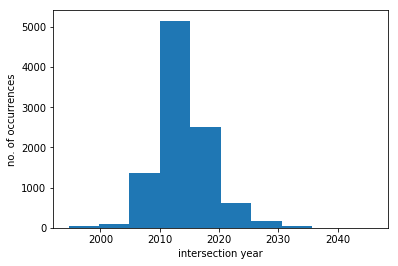

Year of total anthropogenic mass, including anthropogenic mass waste, intersection with dry biomass: mean = 2013 std = 5


In [7]:
# Year of intersection of total anthropogenic mass, including anthropogenic mass waste
hx1 = plt.hist(year_total_dry)
plt.xlabel("intersection year")
plt.ylabel("no. of occurrences")
plt.show()
print "Year of total anthropogenic mass, including anthropogenic mass waste, intersection with dry biomass: mean = " + str(int(np.floor(np.mean(year_total_dry)))) + " std = " + str(int(np.round(np.std(year_total_dry))))

### anthropogenic mass vs. wet biomass

In [8]:
anth_in_use_wet, anth_waste_wet, anth_total_wet, year_in_use_wet, year_total_wet = get_year_uncertainty(BM_wet_MC,num_of_iterations )


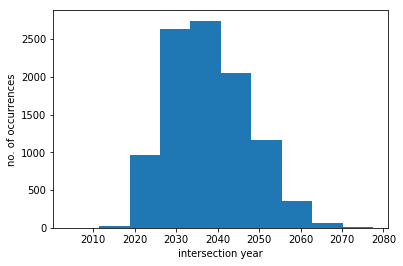

Year of anthropogenic mass intersection with wet biomass: mean = 2037 std = 10


In [9]:
# Year of intersection of anthropogenic mass
hx2 = plt.hist(year_in_use_wet)
plt.xlabel("intersection year")
plt.ylabel("no. of occurrences")
plt.show()
print "Year of anthropogenic mass intersection with wet biomass: mean = " +  str(int(np.floor(np.mean(year_in_use_wet)))) + " std = " + str(int(np.round(np.std(year_in_use_wet))))

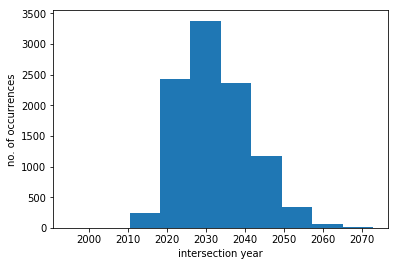

Year of total anthropogenic mass, including anthropogenic mass waste, intersection with wet biomass: mean = 2032 std = 9


In [10]:
# Year of intersection of total anthropogenic mass, including anthropogenic mass waste 
hx1 = plt.hist(year_total_wet)
plt.xlabel("intersection year")
plt.ylabel("no. of occurrences")
plt.show()
print "Year of total anthropogenic mass, including anthropogenic mass waste, intersection with wet biomass: mean = " + str(int(np.floor(np.mean(year_total_wet)))) + " std = " + str(int(np.round(np.std(year_total_wet))))